In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal

try:
    import mpld3
    mpld3.enable_notebook()
    print("Modul mpld3 is installed.")
except:
    print("Modul mpld3 is NOT installed.")

def plot_signal(x, x_label = "", y_label = "", title = "", show = True):
    """ Function that plots signal in Time domain. """
    plt.plot(x)
    plt.xlabel(x_label); plt.ylabel(y_label); plt.title(title);
    if show:
        plt.show();

def plot_spectrum(x, x_label = "", y_label = "", title = "", dB = True, show = True):
    """ Function that plots signal in Frequency domain. """
    n = len(x)
    F = np.fft.fftshift(np.fft.fftfreq(n))
    X = np.fft.fftshift(abs(np.fft.fft(x)))
    if dB:
        X = 20 * np.log10(X)
        X -= np.max(X)
    plt.plot(F, X)
    plt.xlabel(x_label); plt.ylabel(y_label); plt.title(title);
    if show:
        plt.show();

def plot_sonar(x, fs, c, slope, title="", show=True, **kwargs):
    n = len(x)
    F = np.fft.fftfreq(n)
    dist = F * fs * c / 2 / slope
    dist = dist[:n//2]
    X = abs(np.fft.fft(x))[:n//2]
    X_dB = 20 * np.log10(X)
    X_dB -= np.max(X_dB)
    # Threshold value
    th = -10
    # Find peaks above the threshold
    peaks, _ = signal.find_peaks(X_dB, height=th)
    # Convert indices to distances 
    distance_peaks = np.array(peaks) / n * fs * c / 2 / slope

    # fig = plt.figure(figsize=(6, 4))
    plt.plot(dist, X_dB)
    plt.plot(distance_peaks, X_dB[peaks], "x")
    # Annotate each peak with its distance
    for i, peak in enumerate(distance_peaks):
        plt.annotate(f'{peak:.2f} m', (peak + 0.3, X_dB[peaks][i]))
    plt.xlabel("Distance [m]")
    plt.ylabel("|X| dB")
    # plt.title(title if title else f"Spectrum of TX and RX channel product, fs = {round(fs / D / 1e3)} kHz")
    plt.title(title)
    plt.ylim([min(X_dB), 10])
    
    if show:
        plt.show()

def plot_FIR(fir_coeff, x_label = "", y_label = "", title = "", show = True):
    """ Function that plots FIR impulse response in dB. """
    w, h = signal.freqz(fir_coeff)
    H = 20 * np.log10(abs(h))
    plt.plot(w / (2 * np.pi), H)
    plt.plot([1 / (2 * D) - transition_width, 1 / (2 * D) - transition_width], [np.min(H), 0], "r--")
    plt.plot([1 / (2 * D), 1 / (2 * D)], [np.min(H), 0], "r--");
    plt.plot([1 / (2 * D) + transition_width, 1 / (2 * D) + transition_width], [np.min(H), 0], "r--")
    plt.xlabel(x_label); plt.ylabel(y_label); plt.title(title);
    if show:
        plt.show();

def stem_FIR(x, x_label = "", y_label = "", title = "", show = True):
    """ Function that stems FIR's coeffitients. """
    plt.stem(x)
    plt.xlabel(x_label); plt.ylabel(y_label); plt.title(title);
    if show:
        plt.show();

def gen_FIR(n_FIR, D, transition_width):
    """ Function that generates FIR coeffitients based on number of coeffitients and transititon zone. """
    fir_response = [1.0, 1.0, 0.0, 0.0]
    fir_freqs = [0.0, 1 / (2 * D) - transition_width, 1 / (2 * D) + transition_width, 0.5]
    fir_coeff = signal.firls(n_FIR, fir_freqs, fir_response, fs = 1)
    return fir_coeff

def gen_FIR_opt(n_FIR, D, ripple, attenuation, transition_width, symetric = True):
    """ Function that generates FIR coeffitients based on ripple in pass band and attenuation in non-passed band. """
    num_taps = n_FIR
    fir_response = [1.0, 1.0, 0.0, 0.0]
    fir_freqs = [0.0, 1 / (2 * D) - transition_width, 1 / (2 * D) + transition_width, 0.5]
    if not symetric:
        fir_freqs[2] = 1 / (2 * D)
        
    while(True):
        fir_coeff = signal.firls(num_taps, fir_freqs, fir_response, fs = 1)
        w, h = signal.freqz(fir_coeff)
        H = 20 * np.log10(abs(h))
        ripple_ = np.max(H[:int(len(H) * 2*fir_freqs[1])]) - np.min(H[:int(len(H) * 2*fir_freqs[1])])
        attenuation_ = np.max(H[int(len(H) * 2*fir_freqs[2]):])
        if(ripple_ <= ripple and -attenuation_ >= attenuation):
            break
        else:
            num_taps += 2
    return fir_coeff

def gen_test_spectrum(n, freq, amp, rand_phase = False):
    ''' Generate test spectrum
         Arguments:
            n    - number of samples
            freq - tuple of digital frequencies (startFreq, endFreq) in range (0, 0.5)
            amp  - tuple of amplitudes (ampStart, ampEnd)
            randPhase - if True, assign random phase to each sample '''
    freq_start, freq_end = freq
    amp_start, amp_end = amp
    ind_start = round(n * freq_start)
    ind_end = round(n * freq_end)
    x = np.zeros(n, dtype = "complex128")
    x[ind_start : ind_end] = amp_start - np.linspace(0, 1, num = ind_end - ind_start) * (amp_start - amp_end)
    if rand_phase:
        x[ind_start : ind_end] *= np.exp(1j * 2 * np.pi * np.random.rand(ind_end - ind_start))
    x[0] = abs(x[1]) / 2

    x_time_domain = np.fft.ifft(x)
    return x_time_domain


Modul mpld3 is installed.


In [2]:
def make_polyphase_coeff(coeff, M):
    """ Function that generates polyphase coeffitients out of FIR coeffititents. """
    n = int(np.ceil(len(coeff) / M))
    tmp = np.zeros(M * n)
    tmp[:len(coeff)] = coeff
    poly_coeff = np.zeros((M, n))
    for m in range(M):
        poly_coeff[m, :] = tmp[m::M]
    return poly_coeff

def fir_direct(x, coeff, state = None):
    if state == None:
        delay_line = np.zeros(len(x))
    else:
        delay_line = state
    y = np.zeros(len(x))
    for n in range(len(x)):
        delay_line[1:] = delay_line[:-1]
        delay_line[0] = x[n]
        for m in range(len(coeff)):
            y[n] += coeff[m] * delay_line[m]
    return y

def decimate_polyphase(x, coeff, D):
    poly_coeff = make_polyphase_coeff(coeff, D)
    x_periodic = np.concatenate((x, x[:len(coeff)-1]))
    y = 0
    for d in range(D):
        fir_in = x_periodic[d::D]
        tmp = fir_direct(fir_in, poly_coeff[D-1-d])
        # tmp = signal.lfilter(poly_coeff[D-1-d], 1, fir_in)
        tmp = tmp[int(len(coeff)/D):]
        y += tmp
    return y

## <center> Decimation of Test Signal in __Floating-Point__ Arithmetic

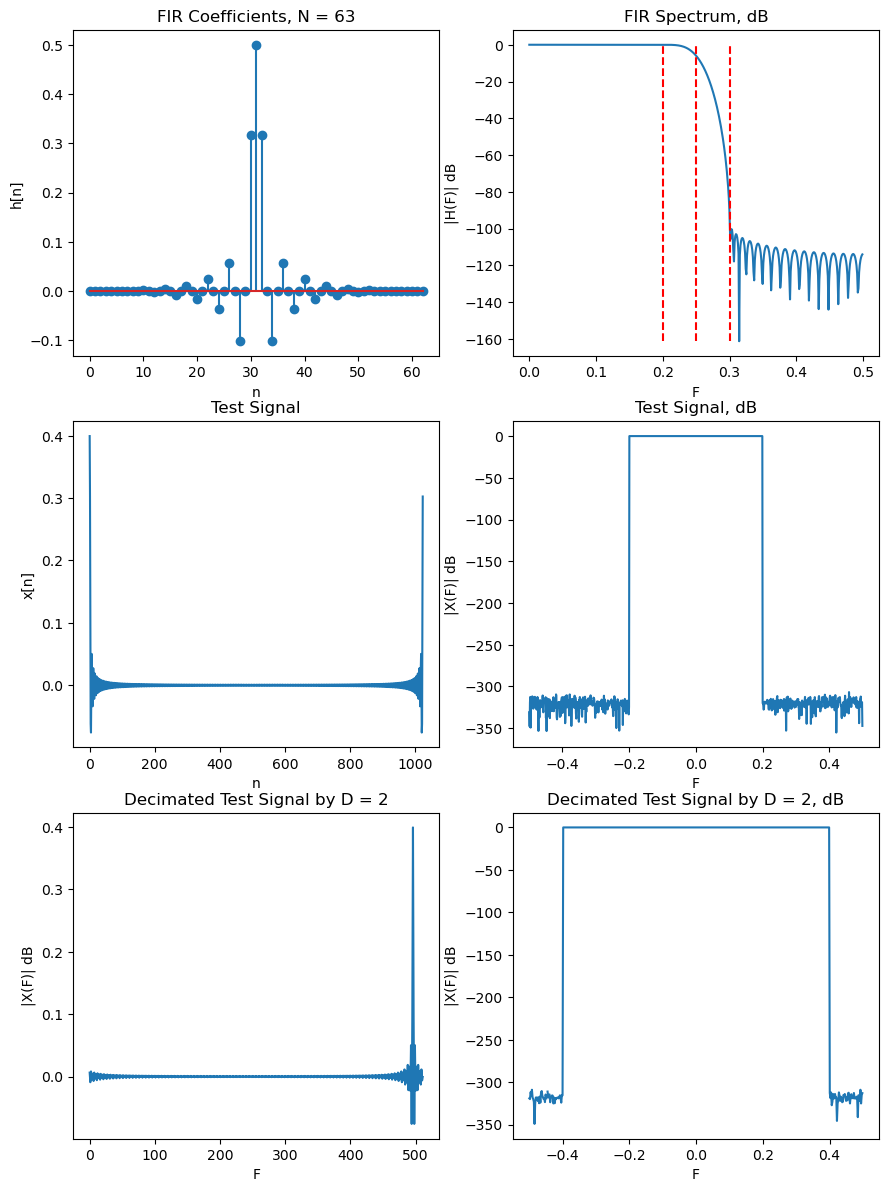

In [3]:
D = 2
# Generate Test signal
n = 1024
f_max = 0.2
f = [0.0, f_max]
a = [1.0, 1]
x = 2*gen_test_spectrum(n, f, a, False).real

# Generate FIR Coefficient
n_FIR = 1
ripple = 1e-3
attenuation = 90 # in dB
transition_width = 0.05
fir_coeff = gen_FIR_opt(n_FIR, D, ripple, attenuation, transition_width, symetric = True)

# Perform decimation by D
x_decimated = decimate_polyphase(x, fir_coeff, D)

# Plot results
figH = 4
ax_x = 3; ax_y = 2
plt.subplots(ax_x, ax_y, figsize=(2.6 * figH, 3.6 * figH))
plt.subplot(ax_x, ax_y, 1)
stem_FIR(fir_coeff, 'n', 'h[n]', f"FIR Coefficients, N = {len(fir_coeff)}", show = False)
plt.subplot(ax_x, ax_y, 2)
plot_FIR(fir_coeff, 'F', '|H(F)| dB', "FIR Spectrum, dB", show = False)
plt.subplot(ax_x, ax_y, 3)
plot_signal(x, 'n', 'x[n]', "Test Signal", show = False)
plt.subplot(ax_x, ax_y, 4)
plot_spectrum(x, 'F', '|X(F)| dB', "Test Signal, dB", show = False)
plt.subplot(ax_x, ax_y, 5)
plot_signal(x_decimated, 'F', '|X(F)| dB', f"Decimated Test Signal by D = {D}", show = False)
plt.subplot(ax_x, ax_y, 6)
plot_spectrum(x_decimated, 'F', '|X(F)| dB',  f"Decimated Test Signal by D = {D}, dB", show = False)

## <center> Decimation of Sonar Signal in ___Floating-Point___ Arithmetic

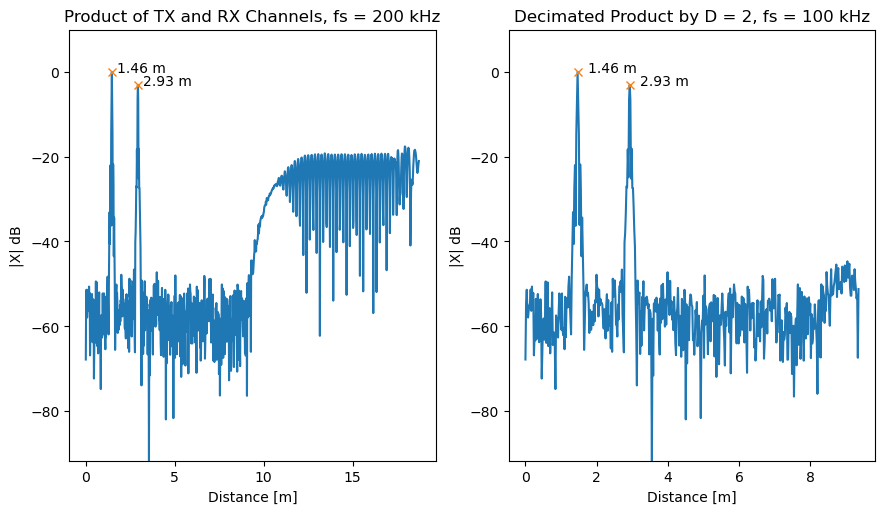

In [4]:
import pprint
import scipy.io

file_path = r"..\sonar_signals.mat"
# Load the .mat file
mat_data = scipy.io.loadmat(file_path)
rx_chirp = np.array(mat_data['rxChirp'])[0]
tx_chirp = np.array(mat_data['txChirp'])[0]
# Product of RX and TX channels (output of mixer)
product = rx_chirp * tx_chirp

time = 0.01       # In seconds
c = 1500          # In m/s
fs = 200e3        # In Hz
f_start = 20e3    # In Hz
f_end = 60e3      # In Hz
slope = (f_end - f_start) / time

# Decimation of product
product_decimated = decimate_polyphase(product, fir_coeff, D)

# Plot results
figH = 4
ax_x = 1; ax_y = 2
plt.subplots(ax_x, ax_y, figsize=(2.6 * figH, 1.4 * figH))
plt.subplot(ax_x, ax_y, 1)
plot_sonar(product, fs, c, slope, title=f"Product of TX and RX Channels, fs = {int(fs/1e3)} kHz", show=False)
plt.subplot(ax_x, ax_y, 2)
plot_sonar(product_decimated, fs/D, c, slope, title=f"Decimated Product by D = {D}, fs = {int(fs/D/1e3)} kHz", show=False)

## <center> Decimation of Test Signal in __Fixed-Point__ Arithmetic

In [5]:
from fxpmath import Fxp

def fir_direct_fixed(x, coeff, state = None):
    if state == None:
        delay_line = Fxp(np.zeros(len(coeff)), like = x)
    else:
        delay_line = state
    y = Fxp(np.zeros(len(x)), like = x)
    y.overflow, y.rounding = x.overflow, x.rounding
    acc = Fxp(0, like = delay_line[0]*coeff[0])
    acc.overflow, acc.rounding = x.overflow, x.rounding
    for n in range(len(x)):
        delay_line[1:] = delay_line[:-1]
        delay_line[0] = x[n]
        acc(0)
        for m in range(len(coeff)):
            acc(acc + delay_line[m] * coeff[m])
        y[n] = (acc)
    y = Fxp(y, like = x)
    return y

def decimate_polyphase_fixed(x, coeff, D, per = True):
    poly_coeff = make_polyphase_coeff(coeff, D)
    y = Fxp(0, like = x)
    y.overflow, y.rounding = x.overflow, x.rounding
    fir_in = Fxp(np.zeros(int(len(x)/D)), like = x)
    fir_in.overflow, fir_in.rounding = x.overflow, x.rounding
    for d in range(D):
        fir_in(x[d::D])
        tmp = fir_direct_fixed(fir_in, poly_coeff[D-1-d])
        tmp = tmp[int(len(coeff)/D):]
        # print(tmp())
        y(y + tmp)
        # print(y())
    return y


In [118]:
D = 2
# Generate Test signal
n = 1024
f_max = 0.2
f = [0.0, f_max]
a = [1.0, 1]
x = 2*gen_test_spectrum(n, f, a, False).real

# Generate FIR Coefficient
n_FIR = 1
ripple = 1e-3
attenuation = 60 # in dB
transition_width = 0.05
fir_coeff = gen_FIR_opt(n_FIR, D, ripple, attenuation, transition_width, symetric = True)

# overflow moze bit 'saturate' ili 'wrap'
overFlowMethod = 'saturate'
# rounding moze biti 'floor', 'trunc', 'around', 'ceil', 'fix'
roundingMethod = 'trunc'
n_word = 16
n_frac = 15

x_Fxp = Fxp(x, signed = True, n_word = n_word, n_frac = n_frac, overflow = overFlowMethod, rounding = roundingMethod)
h_Fxp = Fxp(fir_coeff, signed = True, n_word = n_word, n_frac = n_frac, overflow = overFlowMethod, rounding = roundingMethod)

x_per = np.concatenate((x, x[:len(fir_coeff)-1]))
x_per_Fxp = Fxp(x_per, like = x_Fxp)
x_decimated_fixed = decimate_polyphase_fixed(x_per_Fxp, h_Fxp, D)

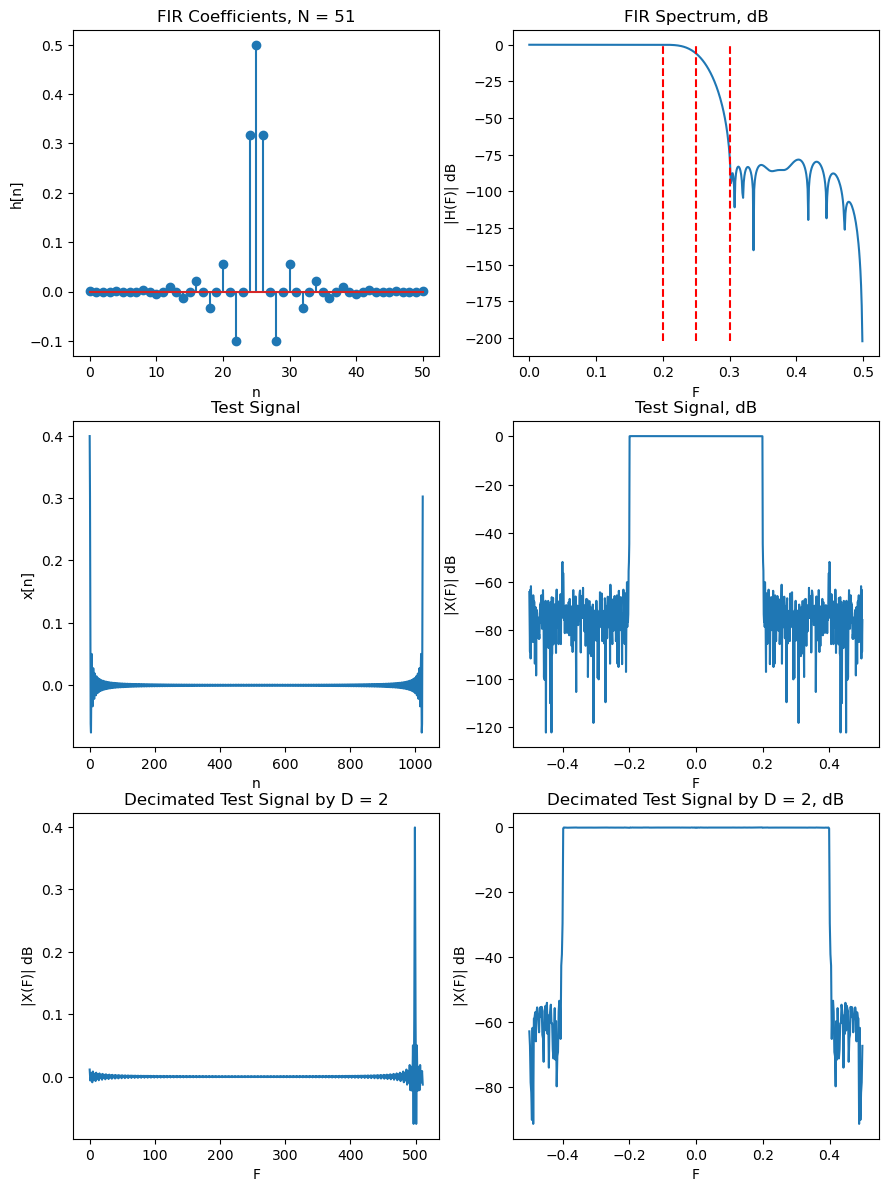

In [119]:
# Plot results
figH = 4
ax_x = 3; ax_y = 2
plt.subplots(ax_x, ax_y, figsize=(2.6 * figH, 3.6 * figH))
plt.subplot(ax_x, ax_y, 1)
stem_FIR(h_Fxp.astype('float'), 'n', 'h[n]', f"FIR Coefficients, N = {len(fir_coeff)}", show = False)
plt.subplot(ax_x, ax_y, 2)
plot_FIR(h_Fxp.astype('float'), 'F', '|H(F)| dB', "FIR Spectrum, dB", show = False)
plt.subplot(ax_x, ax_y, 3)
plot_signal(x_Fxp.astype('float'), 'n', 'x[n]', "Test Signal", show = False)
plt.subplot(ax_x, ax_y, 4)
plot_spectrum(x_Fxp.astype('float'), 'F', '|X(F)| dB', "Test Signal, dB", show = False)
plt.subplot(ax_x, ax_y, 5)
plot_signal(x_decimated_fixed(), 'F', '|X(F)| dB', f"Decimated Test Signal by D = {D}", show = False)
plt.subplot(ax_x, ax_y, 6)
plot_spectrum(x_decimated_fixed(), 'F', '|X(F)| dB',  f"Decimated Test Signal by D = {D}, dB", show = False)

## <center> Decimation of Sonar Signal in ___Fixed-Point___ Arithmetic

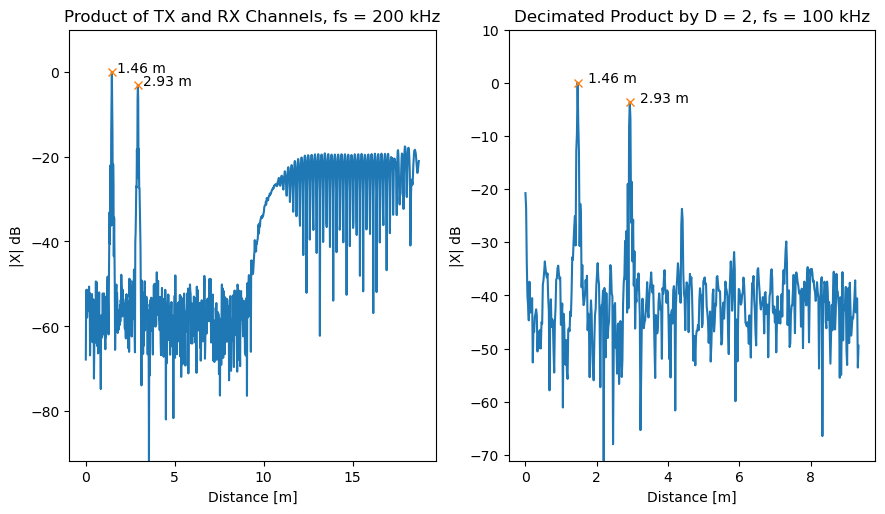

In [120]:
import pprint
import scipy.io

file_path = r"..\sonar_signals.mat"
# Load the .mat file
mat_data = scipy.io.loadmat(file_path)
rx_chirp = np.array(mat_data['rxChirp'])[0]
tx_chirp = np.array(mat_data['txChirp'])[0]
# Product of RX and TX channels (output of mixer)
product = rx_chirp * tx_chirp

time = 0.01       # In seconds
c = 1500          # In m/s
fs = 200e3        # In Hz
f_start = 20e3    # In Hz
f_end = 60e3      # In Hz
slope = (f_end - f_start) / time

product_Fxp = Fxp(product, like = x_Fxp)
product_Fxp.overflow, product_Fxp.rounding = x_Fxp.overflow, x_Fxp.rounding

# Decimation of product
product_decimated_Fxp = decimate_polyphase_fixed(product_Fxp, h_Fxp, D)
product_decimated_Fxp = product_decimated_Fxp()

# Plot results
figH = 4
ax_x = 1; ax_y = 2
plt.subplots(ax_x, ax_y, figsize=(2.6 * figH, 1.4 * figH))
plt.subplot(ax_x, ax_y, 1)
plot_sonar(product, fs, c, slope, title=f"Product of TX and RX Channels, fs = {int(fs/1e3)} kHz", show=False)
plt.subplot(ax_x, ax_y, 2)
plot_sonar(product_decimated_Fxp, fs/D, c, slope, title=f"Decimated Product by D = {D}, fs = {int(fs/D/1e3)} kHz", show=False)

## <center> VHDL Test signal and FIR Coeffitients

In [53]:
# x_in = x_per_Fxp

F1 = 0.13
F2 = 0.41
N = 512
x_in_ = 1e-3*np.sin(2*np.pi*F1*np.arange(N)) + 1e-1*np.sin(2*np.pi*F2*np.arange(N))
x_in_per = np.concatenate((x_in_, x_in_[:len(fir_coeff)-1]))
x_in = Fxp(x_in_per, like = x_Fxp)

x_vhdl = []
for i in range(len(x_in)):
    x_vhdl.append(int(x_in[i]() * 2**n_frac))

# Open a file in write mode
with open(r'..\test_signal.txt', 'w') as file:
    # file.write(str(len(x_vhdl)) + '\n')
    for i in range(len(x_vhdl)):
        if i < len(x_vhdl) - 1:
            file.write(str(x_vhdl[i]) + '\n')
        else:
            file.write(str(x_vhdl[i]))

fir_vhdl  = []
fir1_vhdl = []
fir2_vhdl = []
poly_Fxp = make_polyphase_coeff(h_Fxp, D)

for i in range(int(len(h_Fxp)/D) + 1):
    fir1_vhdl.append(int(poly_Fxp[0, i] * 2**n_frac))
    fir2_vhdl.append(int(poly_Fxp[1, i] * 2**n_frac))

for i in range(len(h_Fxp)):
    fir_vhdl.append(h_Fxp[i].hex())

# Open a file in write mode
with open(r'..\fir_coeff.txt', 'w') as file:
    # file.write(str(len(fir_vhdl)) + '\n')
    for i in range(len(fir_vhdl)):
        if i < len(fir_vhdl) - 1:
            file.write("x\"" + str(fir_vhdl[i][2:]) + "\"" + ',\n')
        else:
            file.write("x\"" + str(fir_vhdl[i][2:]) + "\"")

print(len(fir_vhdl))
# print(f"Coeffitients of first polyphase decomposition:\n{x_vhdl}\n")
print(f"Coeffitients of first polyphase decomposition:\n{fir1_vhdl}\n")
print(f"Coeffitients of second polyphase decomposition:\n{fir2_vhdl}\n")
print(f"Coeffitients of FIR:\n{fir_vhdl}\n")

51
Coeffitients of first polyphase decomposition:
[2, -8, 22, -48, 94, -169, 284, -458, 717, -1118, 1804, -3301, 10370, 10370, -3301, 1804, -1118, 717, -458, 284, -169, 94, -48, 22, -8, 2]

Coeffitients of second polyphase decomposition:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 16384, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Coeffitients of FIR:
['0x0002', '0x0000', '0xFFF8', '0x0000', '0x0016', '0x0000', '0xFFD0', '0x0000', '0x005E', '0x0000', '0xFF57', '0x0000', '0x011C', '0x0000', '0xFE36', '0x0000', '0x02CD', '0x0000', '0xFBA2', '0x0000', '0x070C', '0x0000', '0xF31B', '0x0000', '0x2882', '0x4000', '0x2882', '0x0000', '0xF31B', '0x0000', '0x070C', '0x0000', '0xFBA2', '0x0000', '0x02CD', '0x0000', '0xFE36', '0x0000', '0x011C', '0x0000', '0xFF57', '0x0000', '0x005E', '0x0000', '0xFFD0', '0x0000', '0x0016', '0x0000', '0xFFF8', '0x0000', '0x0002']



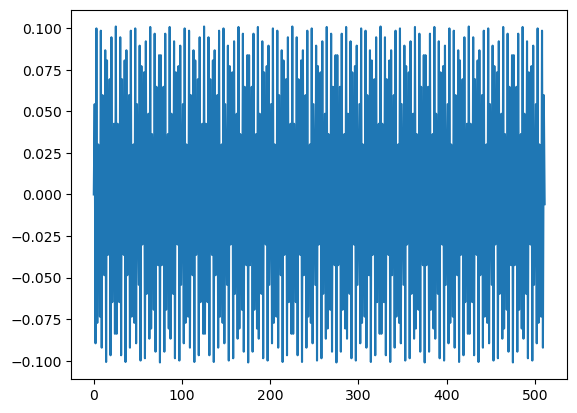

In [52]:
plt.plot(x_in_)

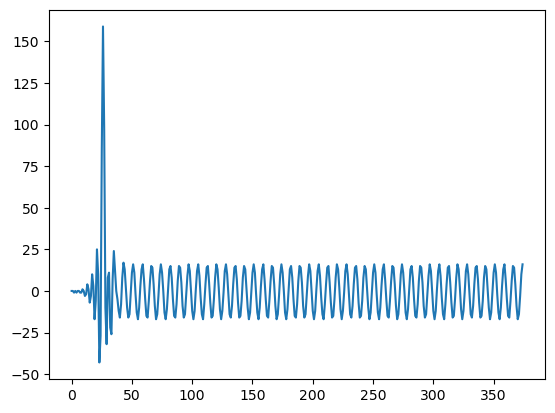

In [71]:
# y = fir_direct_fixed(x_in, h_Fxp)

# Read the data from the text file
y_ = np.loadtxt(r'..\fir_test_signal.txt')
# Display the resulting NumPy array
y_ = np.array(y_)

plt.plot(y_)

In [77]:
print(y_*1e-15 - y[:len(y_)])

[0.0 0.0 -9.998512434661322e-16 0.0 -3.051757812599985e-05 0.0
 3.0517578125e-05 3.051757812400015e-05 -9.155273437599985e-05
 -3.051757812400015e-05 0.000152587890625 6.103515624700001e-05
 -0.0002441406250019999 -9.155273437100016e-05 0.00039672851562599985
 0.00015258789061800017 -0.000640869140628 -0.0002136230468650002
 0.001007080078128 0.00033569335935800014 -0.001556396484381
 -0.0006408691406 0.002593994140635 0.001617431640582 -0.005218505859402
 -0.00973510742179 -0.0059509277342160005 0.0006103515625969999
 0.0019531249999900002 -0.0005187988281569998 -0.0007324218749920001
 0.0013122558593859999 0.001525878906228 -0.0004577636719009998
 -0.0015258789062430002 -0.0007934570312260001 1.1999949645069563e-14
 0.000274658203125 0.0006713867187450001 0.000976562499988
 0.0004577636718590002 -0.0005493164062579999 -0.001068115234367
 -0.0008239746093580001 -0.0001525878906120002 0.0005798339843769999
 0.0009765624999900002 0.0007934570312340002 6.103515623600013e-05
 -0.000701904

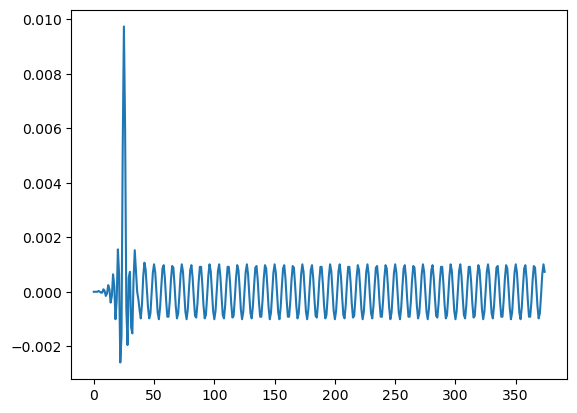

In [83]:
plt.plot(y[:len(y_)])
# plt.plot(y_*1e-15)

In [84]:
yy = []
for i in range(len(y)):
    yy.append(int(y[i]() * 2**15))

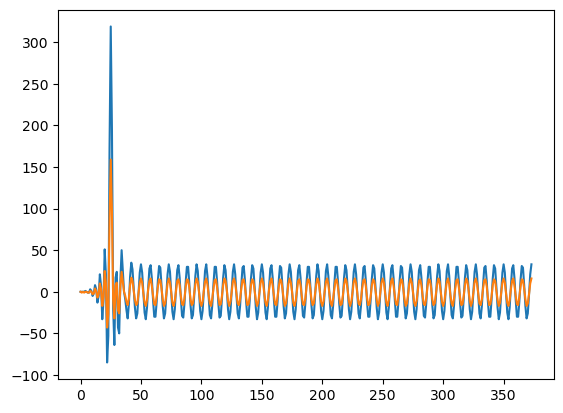

In [90]:
plt.plot(yy[:len(y_)-1])
plt.plot(y_[1:])

In [103]:
F1 = 0.13
F2 = 0.41
N = 512
x_in_ = 1e-3*np.sin(2*np.pi*F1*np.arange(N)) + 1e-1*np.sin(2*np.pi*F2*np.arange(N))
x_in_per = np.concatenate((x_in_, x_in_[:len(fir_coeff)-1]))
x_in = Fxp(x_in_per, like = x_Fxp)

x_fir = []
for i in range(len(x_in)):
    x_fir.append(int(x_in[i]() * 2**15))

h_fir = []
for i in range(len(h_Fxp)):
    h_fir.append((h_Fxp[i]() * 2**15))

# print(h_fir)

x_vhdl = x_fir
# Open a file in write mode
with open(r'..\test_signal.txt', 'w') as file:
    # file.write(str(len(x_vhdl)) + '\n')
    for i in range(len(x_vhdl)):
        if i < len(x_vhdl) - 1:
            file.write(str(x_vhdl[i]) + '\n')
        else:
            file.write(str(x_vhdl[i]))

In [121]:
x_in.overflow, x_in.rounding = x_Fxp.overflow, x_Fxp.rounding

y_fir = fir_direct_fixed(x_in, h_Fxp)

1.9411764705882353


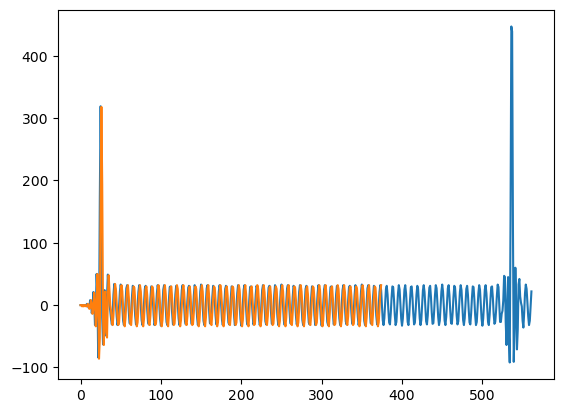

In [122]:
y = []
for i in range(len(y_fir)):
    y.append(int(y_fir[i]() * 2**15))

plt.plot(y)
plt.plot(y_*2)

print(y[100]/y_[101])